In [1]:
import os
import sys
import yaml
import pickle
import argparse

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import zarr
import dask.array as da

from keras.models import load_model

from utils.utility_functions import (transposeZarr, log_transform, clip_outlier_pixels,
compute_vignette_mask, PlotReconstructedImages)

2025-01-08 09:33:20.811852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# select VAE model

# 9um model
# vae_output_dir, clustering, latent_dim, masked_model, std_dev = (
#     'VAE9_VIG7', 'VAE9_VIG7', 412, True, 7
# )

# 30um model
vae_output_dir, clustering, latent_dim, masked_model, std_dev = (
    'VAE30', 'VAE30', 4444, False, None
)

In [3]:
# I/O
root = os.path.join(os.getcwd(), f'input/{vae_output_dir}')

main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# read combined training, validation, and test thumbnails
combo_dir = os.path.join(root, f'6_latent_space_LD{latent_dim}/combined_zarr')
X_combo = zarr.open(combo_dir)

# read segmentation outlines for combined training, validation, and test thumbnails
combo_dir_seg = os.path.join(root, f'6_latent_space_LD{latent_dim}/combined_zarr_seg')
X_combo_seg = zarr.open(combo_dir_seg)

# rearrange Zarr dimensions to conform to expected VAE input
# (i.e. cells, x, y, channels)
X_combo = transposeZarr(z=X_combo)
X_combo_seg = transposeZarr(z=X_combo_seg)

# read SARDANA-097 image contrast settings (defined in CyLinter)
contrast_dir = os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')
contrast_limits = yaml.safe_load(open(contrast_dir))

# read percentile cutoffs generated by feature_preprocessing_selections.py in VAE codebase
with open(os.path.join(root, '4_feature_preprocessing_selections/cutoffs.pkl'), 'rb') as handle:
    percentile_cutoffs = pickle.load(handle)

# load previously saved VAE encoder and decoder
try:
    encoder = load_model(os.path.join(root, '5_train_vae/encoder.hdf5'))
except OSError:
    print('Encoder not found.')
    sys.exit()

try:
    decoder = load_model(os.path.join(root, '5_train_vae/decoder.hdf5'))
except OSError:
    print('Decoder not found.')
    sys.exit()

out = os.path.join(os.getcwd(), f'output/cluster_gallery/{clustering}')
if not os.path.exists(out):
    os.makedirs(out)

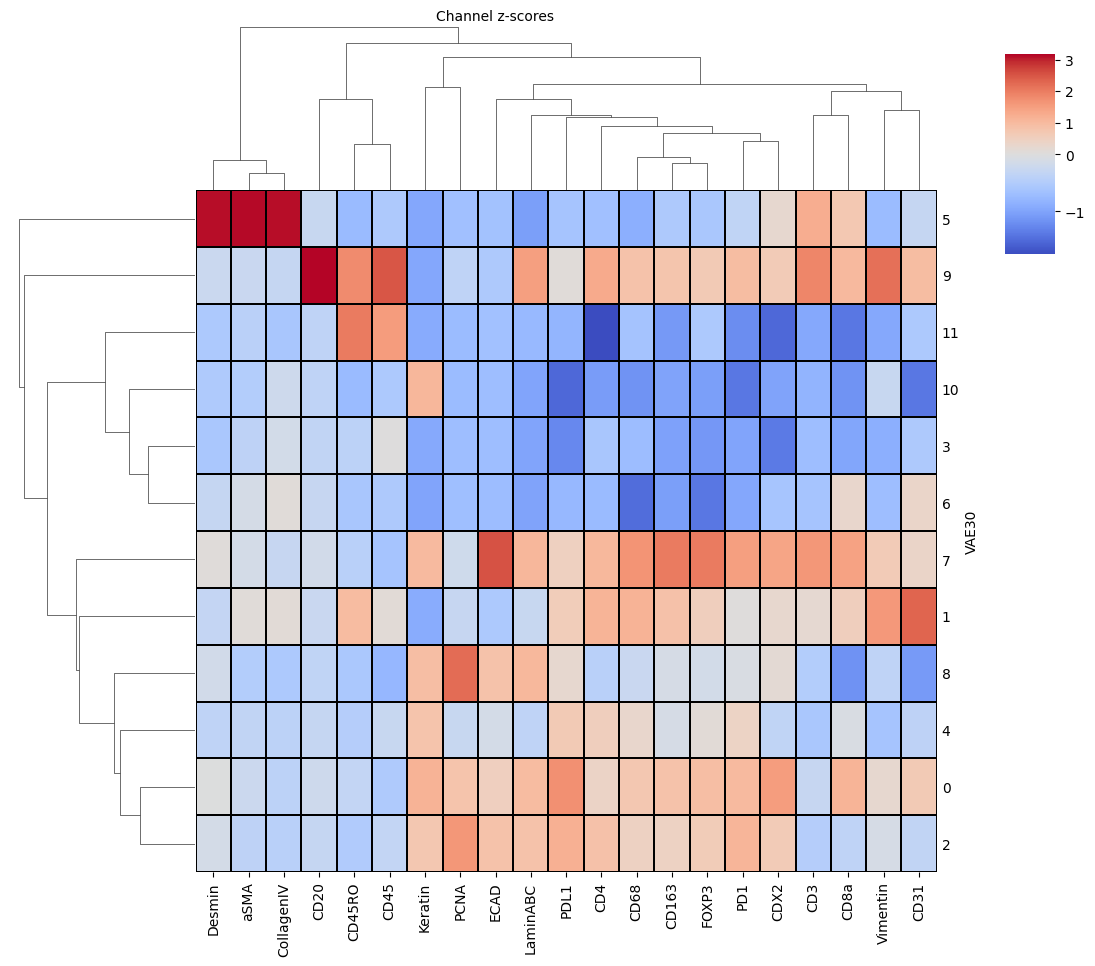

In [4]:
# plot heatmap of median image patch channel intensities
channels = {
    'anti_CD3': 0, 'anti_CD45RO': 1, 'Keratin_570': 2, 'aSMA_660': 3, 'CD4_488': 4, 'CD45_PE': 5,
    'PD1_647': 6, 'CD20_488': 7, 'CD68_555': 8, 'CD8a_660': 9, 'CD163_488': 10, 'FOXP3_570': 11,
    'PDL1_647': 12, 'Ecad_488': 13, 'Vimentin_555': 14, 'CDX2_647': 15, 'LaminABC_488': 16,
    'Desmin_555': 17, 'CD31_647': 18, 'PCNA_488': 19, 'CollagenIV_647': 20
}

antibody_abbrs = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

# compute median values of per patch, per channel pixel intensity medians
medians = da.median(X_combo, axis=(1, 2)).compute()
clustermap_input = pd.DataFrame(columns=[i for i in channels.keys()], data=medians)
clustermap_input[clustering] = main[clustering]
clustermap_input = clustermap_input.groupby(clustering).median()

# compute per channel z-scores across clusters
clustermap_input = (clustermap_input-clustermap_input.mean())/clustermap_input.std()

# zero-center colorbar
norm = TwoSlopeNorm(vcenter=0, vmin=clustermap_input.min().min(), vmax=clustermap_input.max().max())

g = sns.clustermap(
        clustermap_input, cmap='coolwarm', standard_scale=None, yticklabels=1, xticklabels=1,
        linewidths=0.1, linecolor='k', cbar=True, norm=norm 
    )
g.ax_heatmap.set_xticklabels(
    [antibody_abbrs[i.get_text()] for i in g.ax_heatmap.get_xticklabels()], rotation=90
)
g.ax_heatmap.set_yticklabels(
    [i.get_text() for i in g.ax_heatmap.get_yticklabels()], rotation=0
)
g.ax_cbar.set_position([1.01, 0.75, 0.05, 0.2])
g.fig.suptitle('Channel z-scores', y=0.995, fontsize=10)
g.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)
plt.savefig(os.path.join(out, 'channel_z-scores.pdf'), bbox_inches='tight')
plt.show()

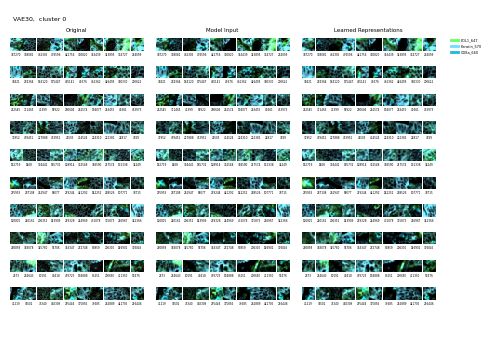

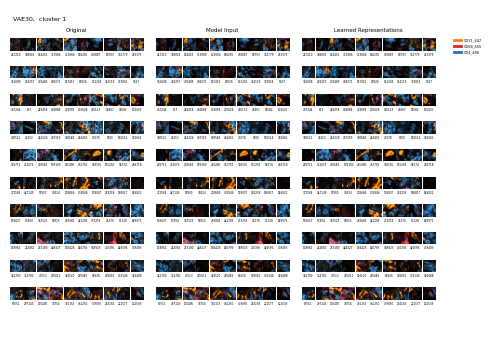

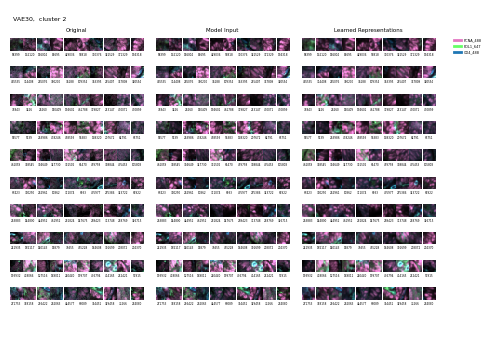

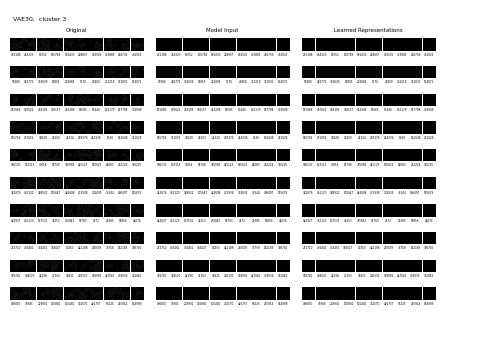

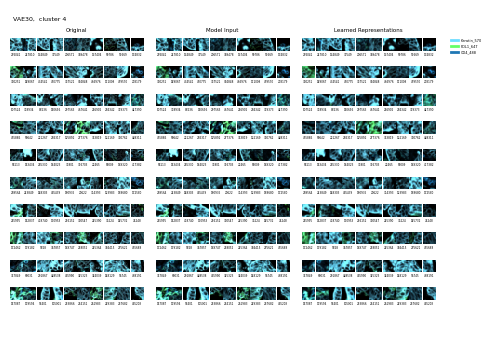

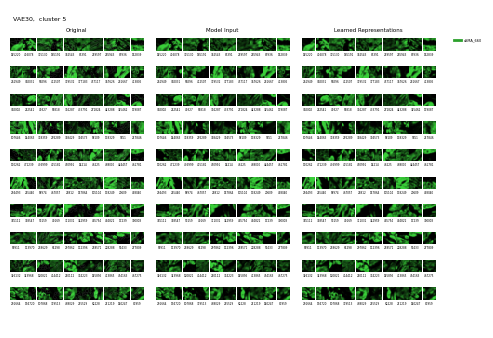

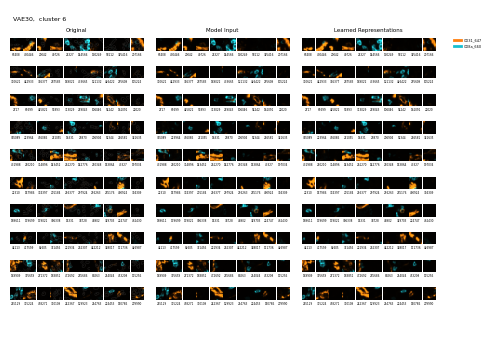

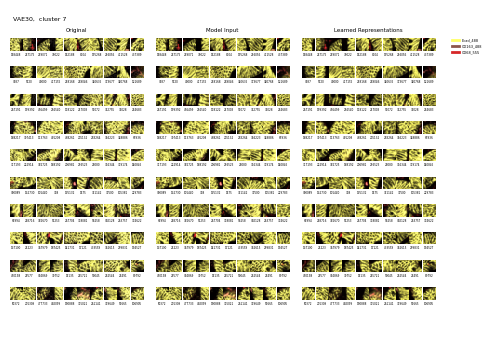

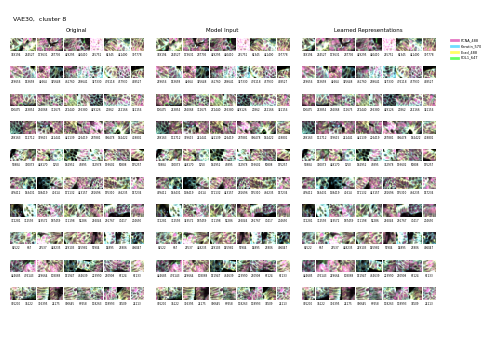

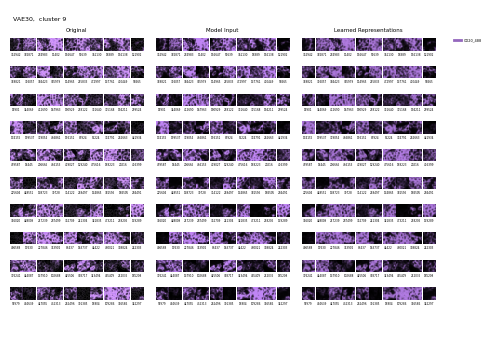

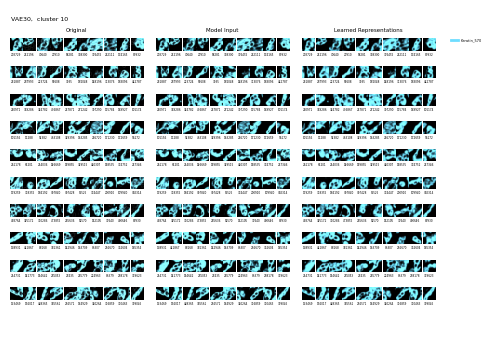

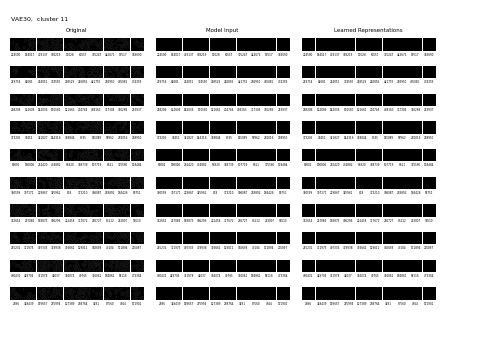

In [5]:
# generate VAE cluster gallery
gallery_size = 100

for clus_name, vae_clus in main.groupby(clustering):
    # if clus_name in [1, 2, 3, 5, 7, 20, 24, 26, 27]:  # example patch clusterr
    channels_sorted = g.data2d.loc[clus_name].sort_values(ascending=False)
    
    # exclude uninformative channels
    channels_sorted = channels_sorted[~channels_sorted.index.isin(['CDX2_647', 'LaminABC_488'])]
    
    top_channels = channels_sorted[channels_sorted > 0.0].index[0:4]  # top 4 > cutoff
    
    ####################
    
    # for fig. 1f,g

    mydict = {
        'CD4_488': 'tab:blue', 'Keratin_570': '#6eddff', 'PCNA_488': 'tab:pink', 'CD68_555': 'tab:red',
        'Ecad_488': '#ffff66', 'CD31_647': 'tab:orange', 'PDL1_647': '#66ff66', 'CD20_488': 'tab:purple',
        'aSMA_660': 'tab:green', 'CD8a_660': 'tab:cyan', 'CD163_488': 'tab:brown'}
    
    # mydict = {'Keratin_570': '#50bfe6', 'anti_CD3': 'tab:red', 'CD4_488': 'tab:blue',
    #           'CD20_488': 'tab:purple', 'CD8a_660': 'tab:gray', 'FOXP3_570': '#66ff66', 
    #           'Ecad_488': '#ffff66', 'CD31_647': 'tab:orange', 'PCNA_488': 'tab:pink',
    #           'aSMA_660': 'tab:cyan'
    #      }
    top_channels = [i for i in top_channels if i in mydict.keys()]
        
    channel_color_dict = dict(
        zip(top_channels, 
            zip([channels[i] for i in top_channels], 
                [mydict[i] for i in top_channels])
            )
    )
    
    ####################
    
    # channel_color_dict = dict(
    #     zip(top_channels, 
    #         zip([channels[i] for i in top_channels], 
    #             ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
    #         )
    # )
    
    if len(vae_clus) >= gallery_size:
        y = vae_clus.sample(n=gallery_size, random_state=0)
    else:
        y = vae_clus.sample(n=len(vae_clus), random_state=0)

    # compute and apply vignette mask
    if std_dev is not None: 
        mask, vmin, vmax = compute_vignette_mask(window_size=X_combo.shape[1], std_dev=std_dev)
    else:
        mask = None

    # log-transform, clip outliers in image patch sample
    X_transformed = clip_outlier_pixels(log_transform(X_combo[y.index]), percentile_cutoffs)

    if masked_model:
        X_transformed *= mask

    # encode sample images
    X_encoded = encoder.predict(X_transformed.compute(), verbose=0)

    # slice segmentation outlines
    X_seg = X_combo_seg[y.index]

    PlotReconstructedImages(
        orig_input_dims=(X_transformed.shape[1], 
                         X_transformed.shape[2],
                         X_transformed.shape[3]),
        percentile_cutoffs=percentile_cutoffs,
        contrast_limits=contrast_limits,
        decoder=decoder,
        X_transformed=X_transformed,
        X_seg=X_seg,
        X_encoded=X_encoded,
        y=y[clustering],
        numColumns=10,
        channel_color_dict=channel_color_dict,
        intensity_multiplier=1.3,
        thumbnail_font_size=3.0,
        filename=f'{clustering},  cluster {clus_name}',
        save_dir=out,
        mask=mask,
        masked_model=masked_model
    )